In [1]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import sigpy
sys.path.append('../../../src/')

# custom scripts
import mri_cs
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion, zero_fill, create_mask

from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Shape: (frame_count, rows, cols)

In [24]:
import matplotlib.image as mpimg
import os

img_dir = "./frames/"
frames = []

for f in sorted(os.listdir(img_dir)):
    img = mpimg.imread(os.path.join(img_dir, f))
    # only take first channel and square image
    img = img[:, 40:280, 0]
    frames.append(img)

frames = np.array(frames)
rows, cols = frames.shape[1:3]
frames.shape

(10, 240, 240)

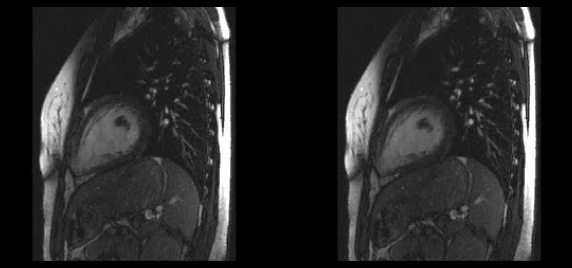

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)
_ = ax[0].imshow(frames[0, ...])
_ = ax[0].axis('off')
_ = ax[1].imshow(frames[-1, ...])
_ = ax[1].axis('off')

0.18338541666666666

(10, 10563)

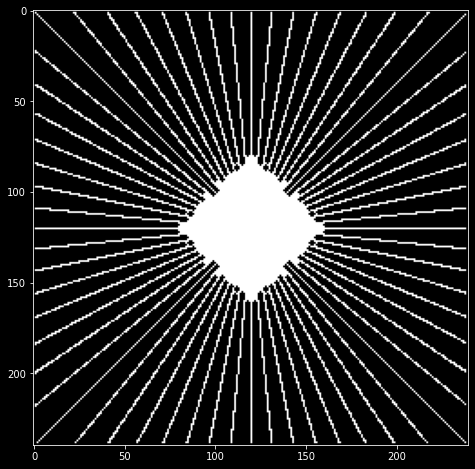

In [25]:
radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 64, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]

b = []
for i in range(frames.shape[0]):
    b.append(np.fft.fft2(frames[i, ...]).flatten()[samples_rows])
    
b = np.array(b)
get_proportion(frames[0, ...].flatten(), b[0])
b.shape

_ = plt.imshow(np.fft.fftshift(radial_mask))

PSNR: 30.75434821501535
SSIM: 0.7773974545053719
SNR: 18.10959759715149
MSE: 73.08341944228573


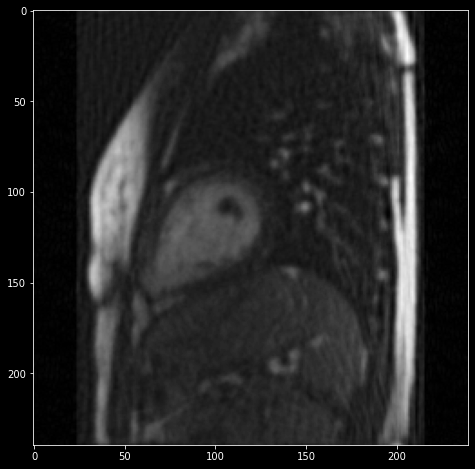

In [26]:
zero_filled = zero_fill(b[0], samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = plt.grid(False)
_ = calculate_metrics(frames[0, ...], np.abs(zero_filled))

# No prior information LP minimization

In [27]:
filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 25.245457410812378s


PSNR: 31.866698873351286
SSIM: 0.8544543190353764
SNR: 19.893601673743426
MSE: 48.463910209287626


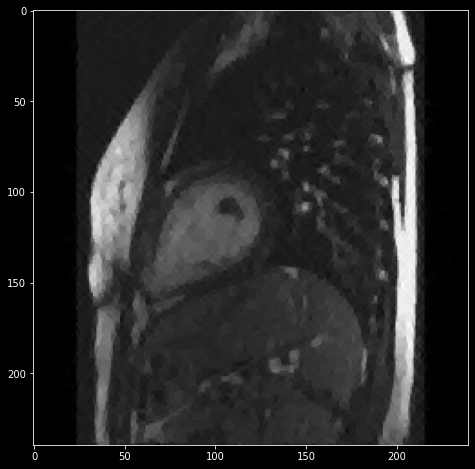

In [28]:
import mri_cs
reload(mri_cs)

tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

frame_recons = []

nopi_recon = mri_cs.prefiltering(samples_rows, b[0], rows=rows, columns=cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

_ = plt.imshow(np.abs(nopi_recon))
_ = calculate_metrics(np.abs(frames[0, ...]), np.abs(nopi_recon))
frame_recons.append(nopi_recon)

# Visualizing prior information leveraged

<module 'mri_cs' from '../../../src/mri_cs.py'>

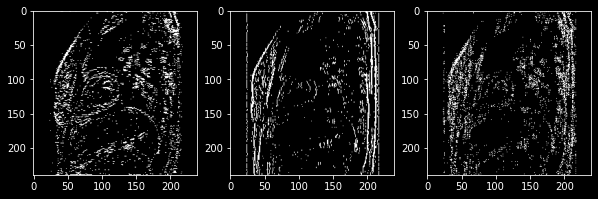

In [80]:
reload(mri_cs)

phi = mri_cs.prior_information(np.abs(frame_recons[0]), pi_prop=8/100, filters=filters)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
_ = ax1.imshow(create_mask(phi[0], rows=rows, cols=cols))
_ = ax2.imshow(create_mask(phi[1], rows=rows, cols=cols))
_ = ax3.imshow(create_mask(phi[2], rows=rows, cols=cols))

PSNR: 30.80261243367289
SSIM: 0.7785117970138763
SNR: 18.097862681142175
MSE: 73.30878974031408


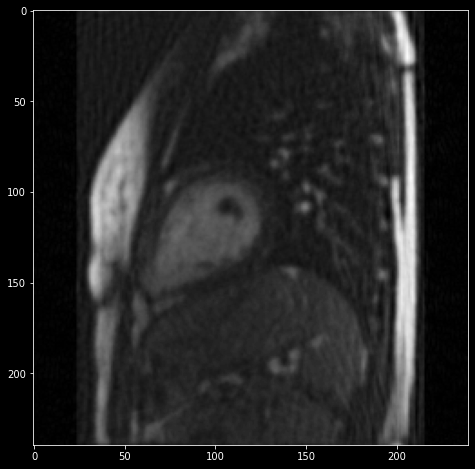

In [87]:
zero_filled = zero_fill(b[1], samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = plt.grid(False)
_ = calculate_metrics(frames[1, ...], np.abs(zero_filled))

<module 'mri_cs' from '../../../src/mri_cs.py'>

(240, 240)

(7488,)

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 23.334303379058838s
PSNR: 31.853801089543765
SSIM: 0.8545445046311917
SNR: 19.825692963617914
MSE: 49.24623367747411


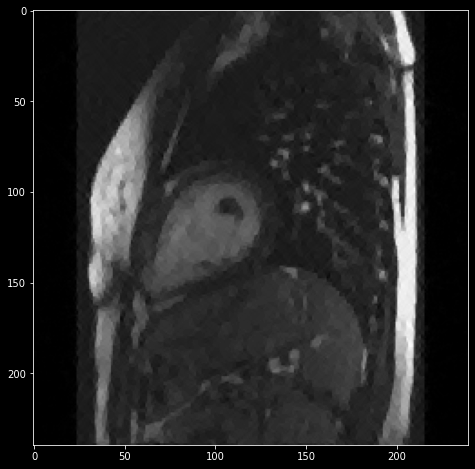

In [77]:
import mri_cs
reload(mri_cs)

rows, cols = frames[1, ...].shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

rows, cols
phi[0].shape

nopi_recon = mri_cs.prefiltering(samples_rows, b[1], rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 maxiterperstage=maxiterperstage, verbose=False)

_ = calculate_metrics(np.abs(frames[1, ...]), np.abs(nopi_recon))
_ = plt.imshow(np.abs(nopi_recon))

# Reconstruct next frame with this recontruction's deterministic prior information

<module 'mri_cs' from '../../../src/mri_cs.py'>

(240, 240)

(4608,)

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 46.12494921684265s
PSNR: 31.21556325377403
SSIM: 0.8414945478142628
SNR: 19.221340425884712
MSE: 56.59893708239306


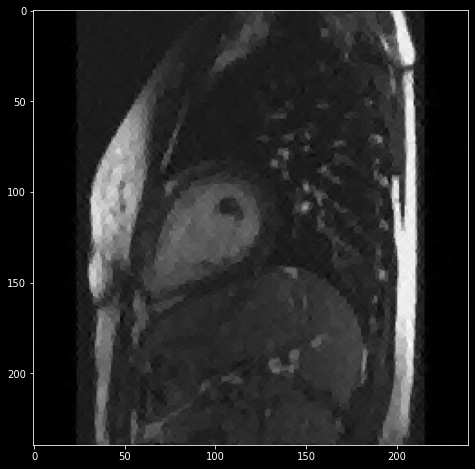

In [81]:
import mri_cs
reload(mri_cs)

rows, cols = frames[1, ...].shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1

rows, cols
phi[0].shape

pi_recon = mri_cs.prefiltering(samples_rows, b[1], rows, cols, h=filters, 
                               p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                               maxiterperstage=maxiterperstage,
                               phi=phi, tau=tau, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(frames[1, ...]), np.abs(pi_recon))

In [82]:
import gaussian_2d_domain
cov_matrix = np.array([[10, 0], [0, 10]])
reload(gaussian_2d_domain)

weights, I, J = gaussian_2d_domain.weights_from_prior(
    phi, rows, cols, taufactor=1e6, taumin=1, cov_matrix=cov_matrix)

<module 'gaussian_2d_domain' from '../../../src/gaussian_2d_domain.py'>

<module 'gaussian_2d_domain' from '../../../src/gaussian_2d_domain.py'>

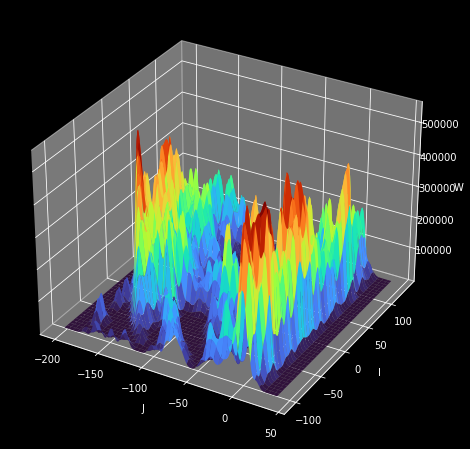

In [83]:
reload(gaussian_2d_domain)
gaussian_2d_domain.visualize3d(weights, J, I, frame=2)

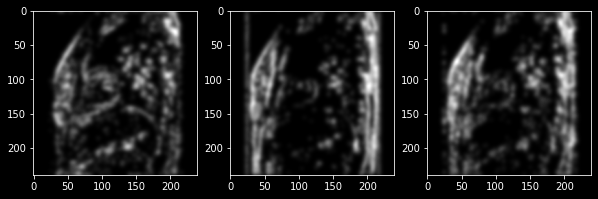

In [84]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    _ = ax[i].imshow(weights[..., i])

<module 'gaussian_mri_cs' from '../../../src/gaussian_mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 87.32703924179077s
PSNR: 32.107246072811705
SSIM: 0.8655220563669475
SNR: 19.80181195694886
MSE: 49.51777500545593


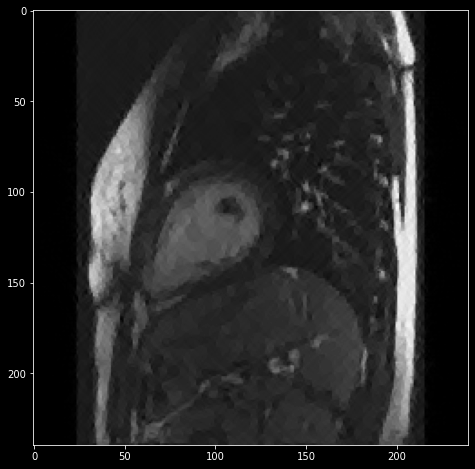

In [85]:
import gaussian_mri_cs
reload(gaussian_mri_cs)

rows, cols = frames[1, ...].shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1

pi_recon = gaussian_mri_cs.prefiltering(samples_rows, b[1], rows, cols, h=filters, 
                                        p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                        maxiterperstage=maxiterperstage,
                                        phi=phi, gaussian_weights=weights, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(frames[1, ...]), np.abs(pi_recon))

In [95]:
from tqdm.notebook import tqdm


det_recons = []
gaus_recons = []
phis = []
weights_list = []
# from second frame onwards
for idx, measurements in tqdm(enumerate(b)):
    # skip first frame
    if idx == 0:
        continue

    determin_recon = mri_cs.prefiltering(samples_rows, b=measurements, rows=rows, columns=cols, h=filters, 
                                         p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                         maxiterperstage=maxiterperstage,
                                         phi=phi, tau=tau, verbose=False)

    det_recons.append(determin_recon)
    
    print(f"\n[Deterministic] Frame [{idx}]")
    _ = calculate_metrics(np.abs(frames[idx, ...]), np.abs(determin_recon))
    print("\n")
    
    phi = mri_cs.prior_information(np.abs(determin_recon), pi_prop=8/100, filters=filters)
    phis.append(phi)
    cov_matrix = np.array([[10, 0], [0, 10]])

    weights, _, _ = gaussian_2d_domain.weights_from_prior(
        phi, rows, cols, taufactor=1e6, taumin=1, cov_matrix=cov_matrix)
    
    weights_list.append(weights)
    
    gaussian_recon = gaussian_mri_cs.prefiltering(samples_rows, b=measurements, rows=rows, columns=cols, h=filters, 
                                                  p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                                  maxiterperstage=maxiterperstage,
                                                  phi=phi, gaussian_weights=weights, verbose=False)

    gaus_recons.append(gaussian_recon)
    print(f"\n[Gaussian] Frame [{idx}]")
    _ = calculate_metrics(np.abs(frames[idx, ...]), np.abs(gaussian_recon))
    print("\n")

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 50.035075187683105s
[Deterministic] Frame [1]
PSNR: 31.21556325377403
SSIM: 0.8414945478142628
SNR: 19.221340425884712
MSE: 56.59893708239306





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 84.21710872650146s
[Gaussian] Frame [1]
PSNR: 32.19850770894243
SSIM: 0.8673372097537267
SNR: 19.841195343033544
MSE: 49.07075991682781


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 48.18225169181824s
[Deterministic] Frame [2]
PSNR: 31.131273941944187
SSIM: 0.8375895972964722
SNR: 19.03378733266852
MSE: 59.09992492596662





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 87.83048224449158s
[Gaussian] Frame [2]
PSNR: 32.13324582071891
SSIM: 0.8639330558007703
SNR: 19.855750343682946
MSE: 48.909207760100756


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 44.306100368499756s
[Deterministic] Frame [3]
PSNR: 31.209801680770216
SSIM: 0.8375622793275769
SNR: 18.884059110134242
MSE: 61.150506853607126





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 88.72800350189209s
[Gaussian] Frame [3]
PSNR: 32.16544522197738
SSIM: 0.8666278724114735
SNR: 19.911016418433768
MSE: 48.27300452433998


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 45.435261726379395s
[Deterministic] Frame [4]
PSNR: 31.061202673323407
SSIM: 0.8339960140544795
SNR: 18.778278131551712
MSE: 62.64843445689989





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 84.00346660614014s
[Gaussian] Frame [4]
PSNR: 32.097550788823575
SSIM: 0.8641832688079366
SNR: 19.81371372265149
MSE: 49.35903536861713


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 50.04339122772217s
[Deterministic] Frame [5]
PSNR: 30.986854021137713
SSIM: 0.8347099509488048
SNR: 18.75650511519501
MSE: 62.93260223276734





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 84.32240033149719s
[Gaussian] Frame [5]
PSNR: 32.04257325252367
SSIM: 0.8635888998977889
SNR: 19.7892380539566
MSE: 49.61378908935036


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 46.608370304107666s
[Deterministic] Frame [6]
PSNR: 31.137050665991175
SSIM: 0.8377343389288566
SNR: 18.803280133343566
MSE: 62.28647411404507





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 83.025963306427s
[Gaussian] Frame [6]
PSNR: 32.04887504600898
SSIM: 0.8662782773777604
SNR: 19.917825567815257
MSE: 48.18803351984964


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 52.38358736038208s
[Deterministic] Frame [7]
PSNR: 31.07819689953348
SSIM: 0.838935240684256
SNR: 18.794249856724193
MSE: 62.4076656432728





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 82.85937356948853s
[Gaussian] Frame [7]
PSNR: 32.59680788597747
SSIM: 0.8743922591840997
SNR: 19.90076000991626
MSE: 48.371206819665495


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 47.34703326225281s
[Deterministic] Frame [8]
PSNR: 31.269821757012796
SSIM: 0.8404987910754719
SNR: 18.698381016631444
MSE: 63.82744806536287





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 93.85946130752563s
[Gaussian] Frame [8]
PSNR: 32.123468995117726
SSIM: 0.8673143109209664
SNR: 19.89349733934837
MSE: 48.47254791807003


####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 55.01858830451965s
[Deterministic] Frame [9]
PSNR: 31.116782755549867
SSIM: 0.8397707991237245
SNR: 18.783164251788598
MSE: 62.606676893096456





####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 80.86745762825012s
[Gaussian] Frame [9]
PSNR: 32.120663924474975
SSIM: 0.867490434336836
SNR: 19.987325193441453
MSE: 47.4465411925985



